In [1]:
import os
import matplotlib.pylab as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from PIL import Image
import pandas as pd
import seaborn as sns

In [2]:
def resize(image_path, size):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(size)
        return np.array(img)
    except Exception as err:
        print("Image ga bisa dibaca! %s" % err)
        return None

In [3]:
def load_dataset(dir):
    size = (150,150)
    images = []
    labels = []
    class_names = os.listdir(dir)
    class_count = {class_name: 0 for class_name in class_names}

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if class_count[class_name] >= 100:
                    break
                img_path = os.path.join(class_dir, file_name)
                img = resize(img_path, size)
                if img is not None:
                    images.append(img)
                    labels.append(class_name)
                    class_count[class_name]+=1
    return np.array(images), np.array(labels), class_names, class_count

In [4]:
dataset_dir = "./Dataset/"

images, labels, class_names, class_count = load_dataset(dataset_dir)

print("Berhasil baca %i citra dari %i kelass." % ((len(images), len(class_names))))
for class_name, count in class_count.items():
    print("Kelas %s punya %i citra." % ((class_name, count)))

Berhasil baca 600 citra dari 6 kelass.
Kelas Coal punya 100 citra.
Kelas Granite punya 100 citra.
Kelas Limestone punya 100 citra.
Kelas Marble punya 100 citra.
Kelas Quartzite punya 100 citra.
Kelas Sandstone punya 100 citra.


Text(0, 0.5, 'Jumlah Citra')

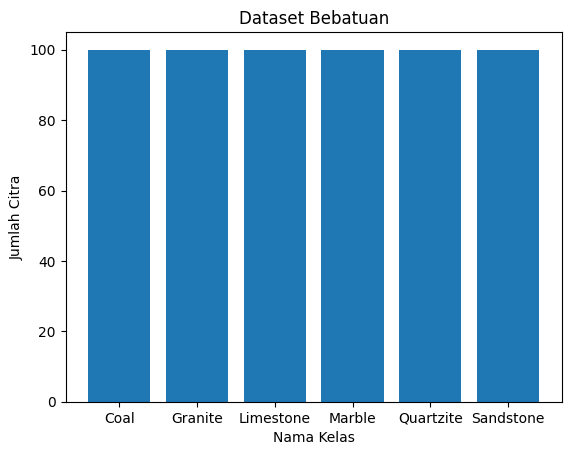

In [5]:
label = list(class_count.keys())
jumlah = list(class_count.values())

plt.bar(label, jumlah)
plt.title("Dataset Bebatuan")
plt.xlabel("Nama Kelas")
plt.ylabel("Jumlah Citra")

Coal


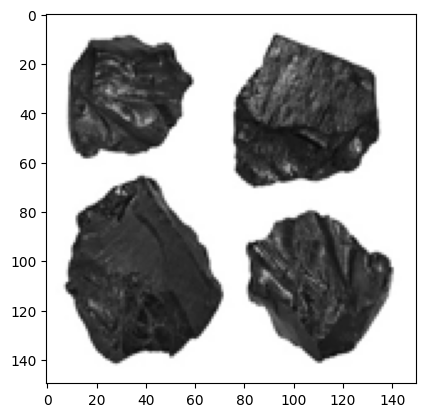

In [6]:
plt.imshow(images[50])
print(labels[50])

In [7]:
images_gray  = []
for image in images:
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images_gray.append(image_gray)

Coal


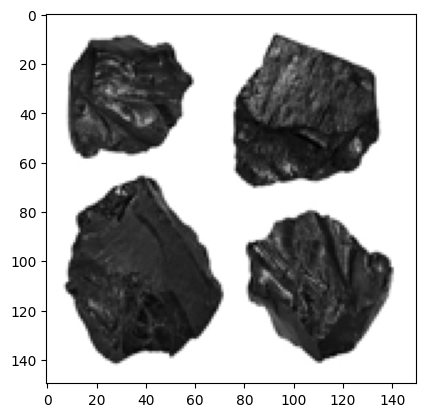

In [8]:
plt.imshow(images_gray[50], cmap='gray')
print(labels[50])

In [9]:
images = np.copy(images_gray)

Quartzite


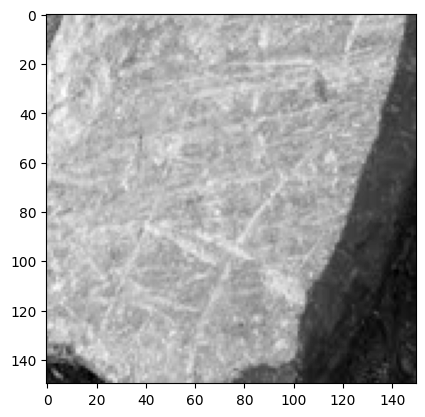

In [10]:
plt.imshow(images[450], cmap='gray')
print(labels[450])

Granite


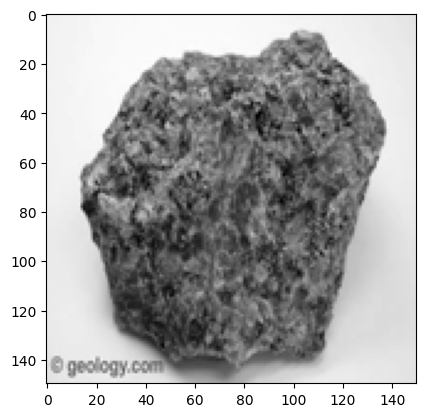

In [11]:
plt.imshow(images[100], cmap='gray')
print(labels[100])

In [12]:
def glcm0(image, jarak):
    max_val = np.max(image)
    tmp = np.zeros([max_val + 1, max_val + 1])

    for i in range(len(image)):
        for j in range(len(image[i]) - jarak):
            tmp[image[i,j], image[i,j+jarak]] += 1
    
    hasil = tmp + tmp.T
    hasil /= np.sum(hasil)
    return hasil

In [13]:
def glcm45(image, jarak):
    max_val = np.max(image)
    tmp = np.zeros([max_val + 1, max_val + 1])

    for i in range(len(image)-jarak):
        for j in range(len(image[i]) - jarak):
            tmp[image[i+jarak,j], image[i,j+jarak]] += 1
    
    hasil = tmp + tmp.T
    hasil /= np.sum(hasil)
    return hasil

In [14]:
def glcm90(image, jarak):
    max_val = np.max(image)
    tmp = np.zeros([max_val + 1, max_val + 1])

    for i in range(len(image)-jarak):
        for j in range(len(image[i])):
            tmp[image[i+jarak,j], image[i,j]] += 1
    
    hasil = tmp + tmp.T
    hasil /= np.sum(hasil)
    return hasil

In [15]:
def glcm135(image, jarak):
    max_val = np.max(image)
    tmp = np.zeros([max_val + 1, max_val + 1])

    for i in range(len(image)-jarak):
        for j in range(len(image[i]) - jarak):
            tmp[image[i,j], image[i+jarak,j+jarak]] += 1
    
    hasil = tmp + tmp.T
    hasil /= np.sum(hasil)
    return hasil

In [16]:
hasil_glcm0 = []
hasil_glcm45 = []
hasil_glcm90 = []
hasil_glcm135 = []

for image in images:
    glcm_0 = glcm0(image, 1)
    glcm_45 = glcm45(image, 1)
    glcm_90 = glcm90(image, 1)
    glcm_135 = glcm135(image, 1)
    hasil_glcm0.append(glcm_0)
    hasil_glcm45.append(glcm_45)
    hasil_glcm90.append(glcm_90)
    hasil_glcm135.append(glcm_135)

In [17]:
def hitung_homogenity(glcm):
    height, width = glcm.shape
    homogenity = 0
    for i in range(height):
        for j in range(width):
            homogenity += glcm[i,j] / (1+abs(i-j))
    return homogenity

In [18]:
def hitung_contrast(glcm):
    height, width = glcm.shape
    contrast = 0
    for i in range(height):
        for j in range(width):
            contrast += (i-j) ** 2 * glcm[i, j]
    return contrast

In [19]:
def hitung_dissimilarity(glcm):
    dissimilarity = 0
    height, width = glcm.shape
    for i in range(height):
        for j in range(width):
            dissimilarity += abs(i-j) * glcm[i, j]
    return dissimilarity

In [20]:
def hitung_energy(glcm):
    asm = np.sum(glcm**2)
    energy = np.sqrt(asm)
    return energy

In [21]:
def hitung_correlation(glcm):
    height, width = glcm.shape
    mean_i = np.sum([i * np.sum(glcm[i, :]) for i in range(height)])
    mean_j = np.sum([j * np.sum(glcm[:, j]) for j in range(width)])
    std_i = np.sqrt(np.sum([((i - mean_i) ** 2) * np.sum(glcm[i, :]) for i in range(height)]))
    std_j = np.sqrt(np.sum([((j - mean_j) ** 2) * np.sum(glcm[:, j]) for j in range(width)]))

    correlation = 0
    for i in range(height):
        for j in range(width):
            correlation += ((i - mean_i) * (j - mean_j) * glcm[i, j]) / (std_i * std_j + 1e-10)
    return correlation

In [22]:
def hitung_entropy(glcm):
    entropy = -np.sum(glcm * np.log2(glcm + 1e-10))
    return entropy

In [23]:
def hitung_asm(glcm):
    asm = np.sum(glcm ** 2)
    return asm

In [24]:
fitur_homogenity = []
fitur_contrast = []
fitur_dissimilarity = []
fitur_energy = []
fitur_correlation = []
fitur_entropy = []
fitur_asm = []

In [25]:
for indeks in range(len(hasil_glcm0)):
    glcm_0 = hasil_glcm0[indeks]
    glcm_45 = hasil_glcm45[indeks]
    glcm_90 = hasil_glcm90[indeks]
    glcm_135 = hasil_glcm135[indeks]

    homogenity_0 = hitung_homogenity(glcm_0)
    contrast_0 = hitung_contrast(glcm_0)
    dissimilarity_0 = hitung_dissimilarity(glcm_0)
    energy_0 = hitung_energy(glcm_0)
    correlation_0 = hitung_correlation(glcm_0)
    entropy_0 = hitung_entropy(glcm_0)
    asm_0 = hitung_asm(glcm_0)

    homogenity_45 = hitung_homogenity(glcm_45)
    contrast_45 = hitung_contrast(glcm_45)
    dissimilarity_45 = hitung_dissimilarity(glcm_45)
    energy_45 = hitung_energy(glcm_45)
    correlation_45 = hitung_correlation(glcm_45)
    entropy_45 = hitung_entropy(glcm_45)
    asm_45 = hitung_asm(glcm_45)

    homogenity_90 = hitung_homogenity(glcm_90)
    contrast_90 = hitung_contrast(glcm_90)
    dissimilarity_90 = hitung_dissimilarity(glcm_90)
    energy_90 = hitung_energy(glcm_90)
    correlation_90 = hitung_correlation(glcm_90)
    entropy_90 = hitung_entropy(glcm_90)
    asm_90 = hitung_asm(glcm_90)

    homogenity_135 = hitung_homogenity(glcm_135)
    contrast_135 = hitung_contrast(glcm_135)
    dissimilarity_135 = hitung_dissimilarity(glcm_135)
    energy_135 = hitung_energy(glcm_135)
    correlation_135 = hitung_correlation(glcm_135)
    entropy_135 = hitung_entropy(glcm_135)
    asm_135 = hitung_asm(glcm_135)

    fitur_homogenity.append([homogenity_0, homogenity_45, homogenity_90, homogenity_135])
    fitur_contrast.append([contrast_0, contrast_45, contrast_90, contrast_135])
    fitur_dissimilarity.append([dissimilarity_0, dissimilarity_45, dissimilarity_90, dissimilarity_135])
    fitur_energy.append([energy_0, energy_45, energy_90, energy_135])
    fitur_correlation.append([correlation_0, correlation_45, correlation_90, correlation_135])
    fitur_entropy.append([entropy_0, entropy_45, entropy_90, entropy_135])
    fitur_asm.append([asm_0, asm_45, asm_90, asm_135])

In [26]:
features_df = pd.DataFrame({
    'homogeneity_0': [i[0] for i in fitur_homogenity],
    'homogeneity_45': [i[1] for i in fitur_homogenity],
    'homogeneity_90': [i[2] for i in fitur_homogenity],
    'homogeneity_135': [i[3] for i in fitur_homogenity],
    'contrast_0': [i[0] for i in fitur_contrast],
    'contrast_45': [i[1] for i in fitur_contrast],
    'contrast_90': [i[2] for i in fitur_contrast],
    'contrast_135': [i[3] for i in fitur_contrast],
    'dissimilarity_0': [i[0] for i in fitur_dissimilarity],
    'dissimilarity_45': [i[1] for i in fitur_dissimilarity],
    'dissimilarity_90': [i[2] for i in fitur_dissimilarity],
    'dissimilarity_135': [i[3] for i in fitur_dissimilarity],
    'energy_0': [i[0] for i in fitur_energy],
    'energy_45': [i[1] for i in fitur_energy],
    'energy_90': [i[2] for i in fitur_energy],
    'energy_135': [i[3] for i in fitur_energy],
    'correlation_0': [i[0] for i in fitur_correlation],
    'correlation_45': [i[1] for i in fitur_correlation],
    'correlation_90': [i[2] for i in fitur_correlation],
    'correlation_135': [i[3] for i in fitur_correlation],
    'entropy_0': [i[0] for i in fitur_entropy],
    'entropy_45': [i[1] for i in fitur_entropy],
    'entropy_90': [i[2] for i in fitur_entropy],
    'entropy_135': [i[3] for i in fitur_entropy],
    'asm_0': [i[0] for i in fitur_asm],
    'asm_45': [i[1] for i in fitur_asm],
    'asm_90': [i[2] for i in fitur_asm],
    'asm_135': [i[3] for i in fitur_asm]
})

features_df['label'] = labels

features_df.head()

features_df.to_csv('hasil_glcm_rotasi_flip_front_back_tanpaaugprepos.csv', index=False)

In [27]:
# ini diuncomment kalo butuh cepet ga perlu nungguin ngitung fitur lagi
# features_df = pd.read_csv("hasil_glcm_rotasi_flip_front_back_tanpaprepos.csv")

In [28]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
features_df['label_new'] = label_encoder.fit_transform(features_df['label'])

In [29]:
features_df = features_df.drop('label', axis=1)

<Axes: >

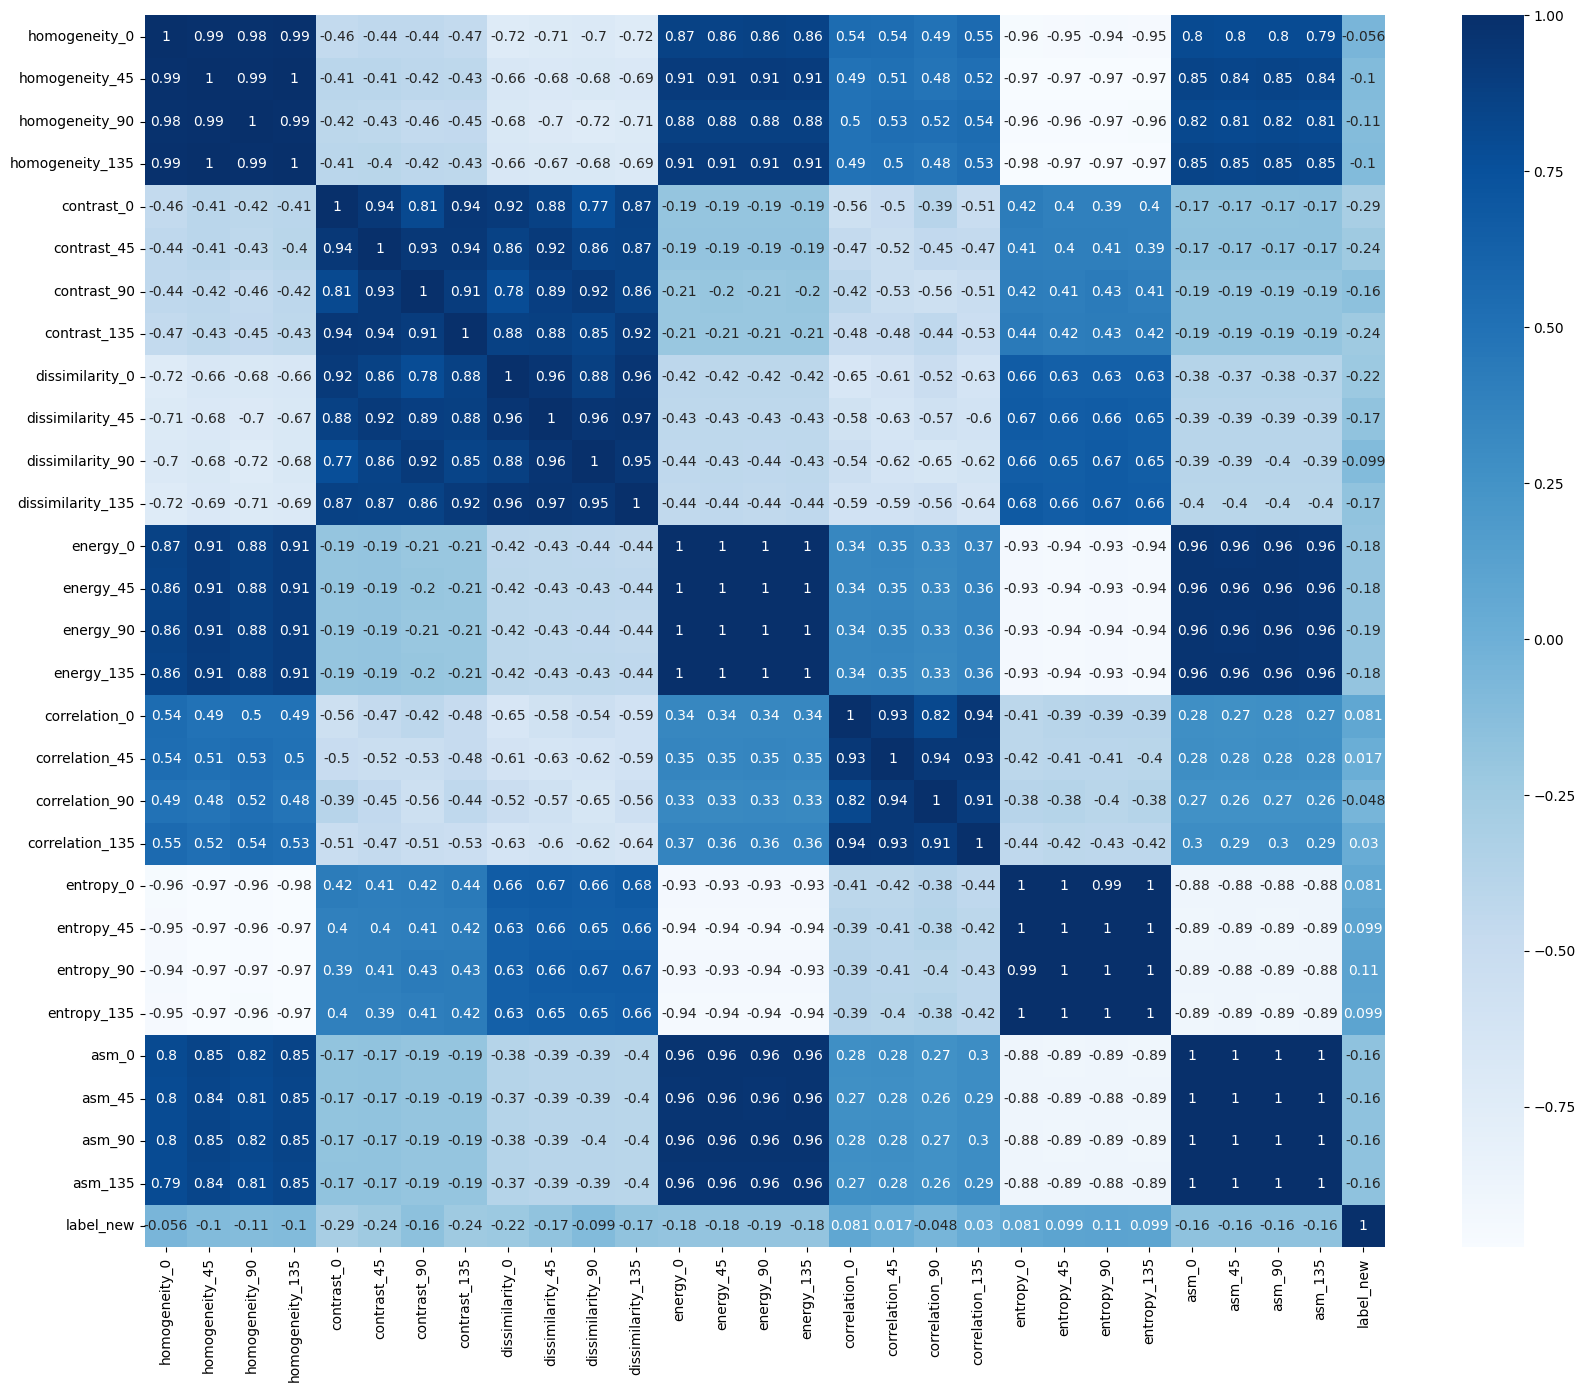

In [30]:
corr_matriks = features_df.corr()
plt.figure(figsize=(20,16))
sns.heatmap(corr_matriks, annot=True, cmap=plt.cm.Blues)

In [31]:
print(corr_matriks.shape)

(29, 29)


In [32]:
print(features_df.shape)

(600, 29)


In [33]:
batas = 0.99

columns = np.full((corr_matriks.shape[0],), True, dtype=bool)

for i in range(corr_matriks.shape[0]):
    for j in range(i + 1, corr_matriks.shape[0]):
        if corr_matriks.iloc[i, j] >= batas:
            if columns[j]:
                columns[j] = False

pilih = features_df.columns[columns]
features_df = features_df[pilih]

<Axes: >

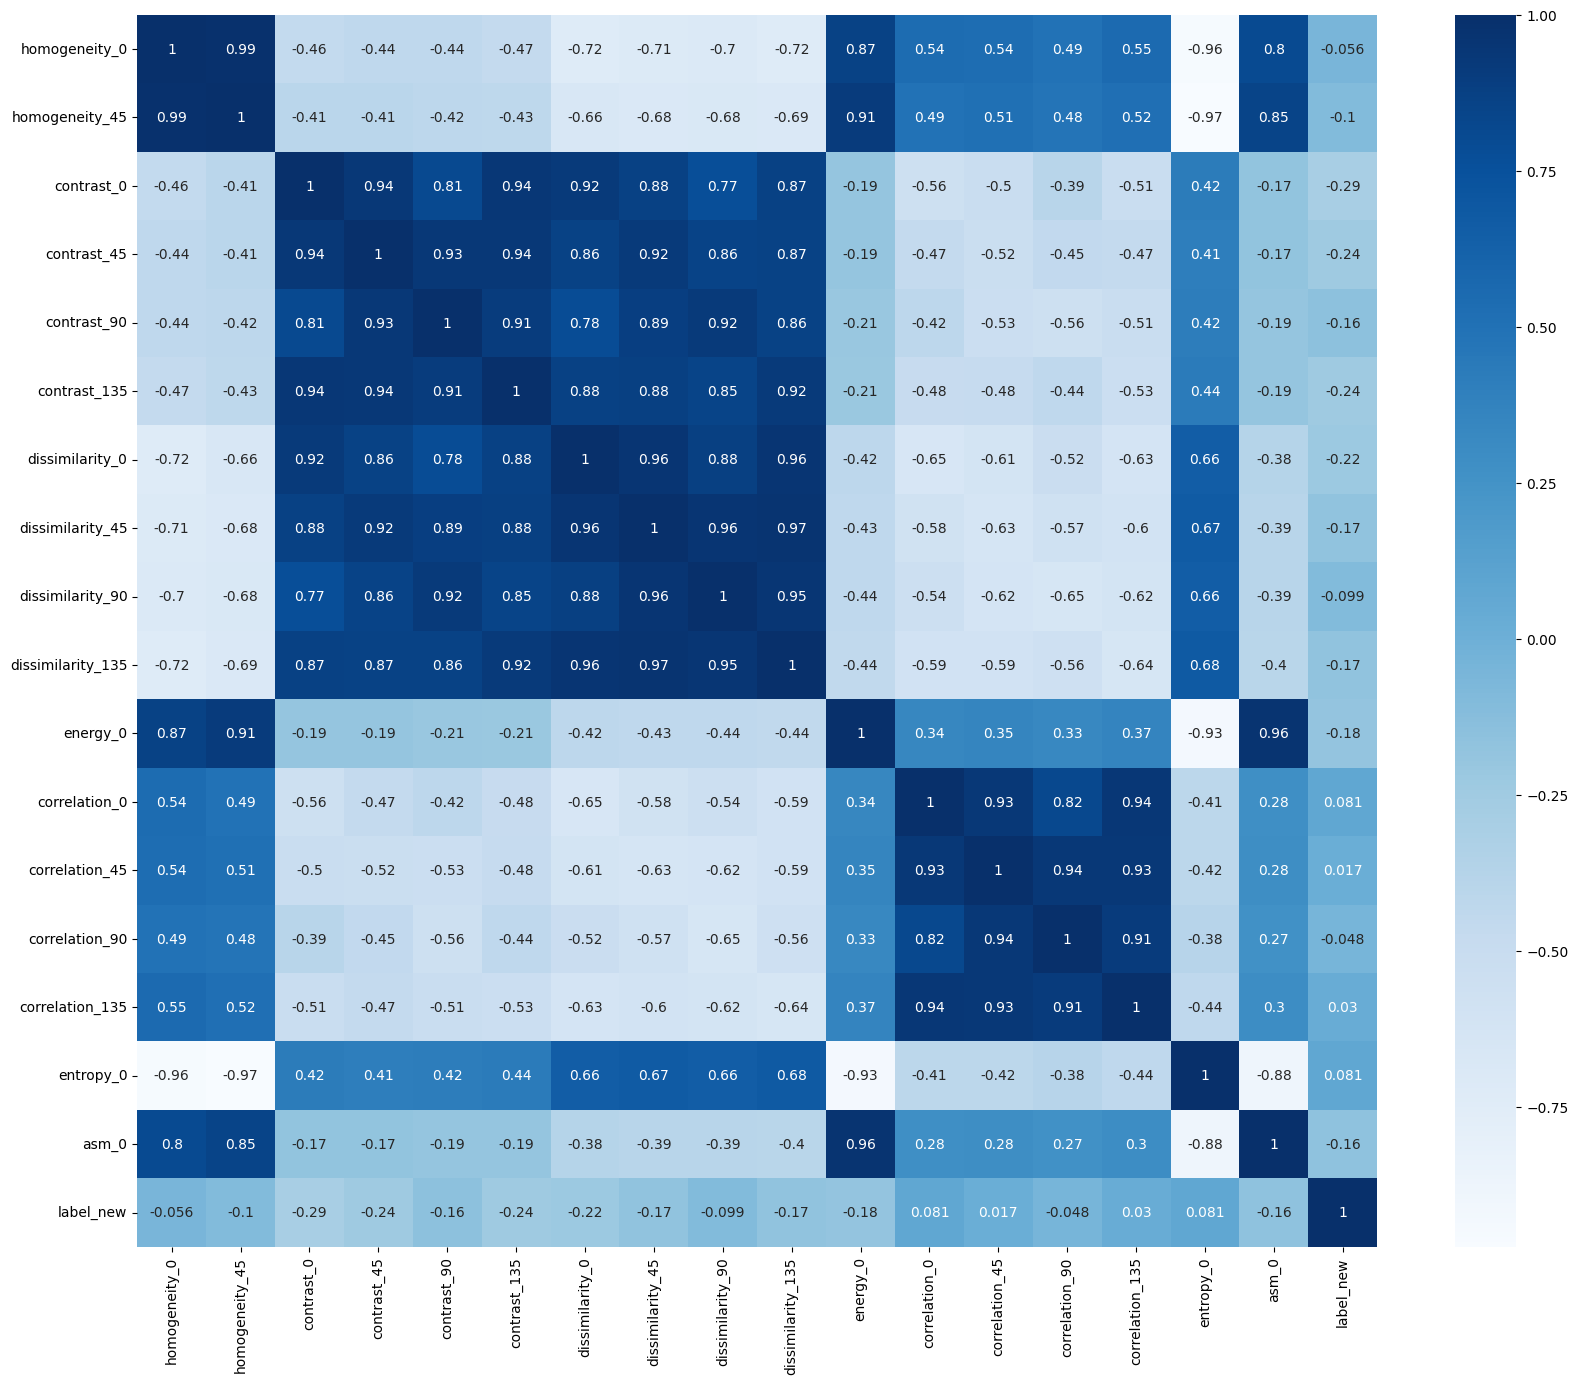

In [34]:
corr_matriks = features_df.corr()
plt.figure(figsize=(20,16))
sns.heatmap(corr_matriks, annot=True, cmap=plt.cm.Blues)

In [35]:
print(corr_matriks.shape)

(18, 18)


In [36]:
x = features_df.drop(columns=['label_new'])
y = features_df['label_new']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=4)

print("x_train ada %i" % len(x_train))
print("y_train ada %i" % len(y_train))
print("x_test ada %i" % len(x_test))
print("y_test ada %i" % len(y_test))

x_train ada 420
y_train ada 420
x_test ada 180
y_test ada 180


In [37]:
def normalisasi(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    data_std = (data-mean)/std
    return data_std

In [38]:
x_train_normal = normalisasi(x_train)
x_test_normal = normalisasi(x_test)

In [39]:
print("Sebelum normalisasi")
print(x_train.head())
print("Setelah normalisasi")
print(pd.DataFrame(x_train_normal, columns=x_train.columns).head())

Sebelum normalisasi
     homogeneity_0  homogeneity_45   contrast_0  contrast_45  contrast_90  \
425       0.191845        0.165150   309.945996   655.410027   442.052931   
168       0.094699        0.085867  1163.888233  1498.822125   933.725056   
573       0.141028        0.110826   453.192662   827.723976   904.204430   
100       0.370909        0.342038   364.975257   507.204901   283.578434   
220       0.258042        0.217192   191.836331   358.243412   163.445056   

     contrast_135  dissimilarity_0  dissimilarity_45  dissimilarity_90  \
425    564.273771        11.869306         16.613486         13.241387   
168   1625.830909        26.264966         29.969100         23.573020   
573   1327.297374        15.448143         21.517860         22.718255   
100    499.771046        11.379463         13.596955         10.066488   
220    232.727084         8.442774         11.599117          7.417673   

     dissimilarity_135  energy_0  correlation_0  correlation_45  \
425  

In [40]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train_normal, y_train)

svm_model = SVC(kernel='linear')
svm_model.fit(x_train_normal, y_train)

rf_model = RandomForestClassifier(n_estimators=3500,random_state=4)
rf_model.fit(x_train_normal, y_train)

y_pred_knn = knn_model.predict(x_test_normal)
y_pred_svm = svm_model.predict(x_test_normal)
y_pred_rf = rf_model.predict(x_test_normal)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Akurasi KNN:", accuracy_knn)
print("Akurasi SVM:", accuracy_svm)
print("Akurasi Random Forest:", accuracy_rf)

Akurasi KNN: 0.31666666666666665
Akurasi SVM: 0.38333333333333336
Akurasi Random Forest: 0.34444444444444444


In [41]:
def cross_validation(x, y, model):
    y_pred = cross_val_predict(model, x, y, cv=5)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    return accuracy, precision, recall, f1

In [42]:
accuracy_knn, precision_knn, recall_knn, f1_knn = cross_validation(x, y, KNeighborsClassifier(n_neighbors=5))
accuracy_svm, precision_svm, recall_svm, f1_svm = cross_validation(x, y, SVC(kernel='linear'))
accuracy_rf, precision_rf, recall_rf, f1_rf = cross_validation(x, y, RandomForestClassifier(n_estimators=3500, random_state=4))

In [43]:
print("Akurasi KNN:", accuracy_knn)
print("Precision KNN:", precision_knn)
print("Recall KNN:", recall_knn)
print("F1-Score KNN:", f1_knn)

print("Akurasi SVM:", accuracy_svm)
print("Precision SVM:", precision_svm)
print("Recall SVM:", recall_svm)
print("F1-Score SVM:", f1_svm)

print("Akurasi Random Forest:", accuracy_rf)
print("Precision Random Forest:", precision_rf)
print("Recall Random Forest:", recall_rf)
print("F1-Score Random Forest:", f1_rf)

Akurasi KNN: 0.24333333333333335
Precision KNN: 0.24339475345976777
Recall KNN: 0.24333333333333332
F1-Score KNN: 0.23562388096183307
Akurasi SVM: 0.2916666666666667
Precision SVM: 0.2921271253027468
Recall SVM: 0.2916666666666667
F1-Score SVM: 0.28428670469101763
Akurasi Random Forest: 0.37333333333333335
Precision Random Forest: 0.3701185444155148
Recall Random Forest: 0.37333333333333335
F1-Score Random Forest: 0.37085044389434546
